In [1]:
import numpy as np

from ipywidgets import interact
from matplotlib import pyplot as plt
from scipy.linalg import cholesky, solve, solve_triangular

%matplotlib inline

# Q1

Empirical (maximum likelihood) fit for Class 1:
Prior probability: 0.7143
Mean: 0.2600
Standard Deviation: 0.1287

Empirical (maximum likelihood) fit for Class 2:
Prior probability: 0.2857
Mean: 0.8625
Standard Deviation: 0.1109


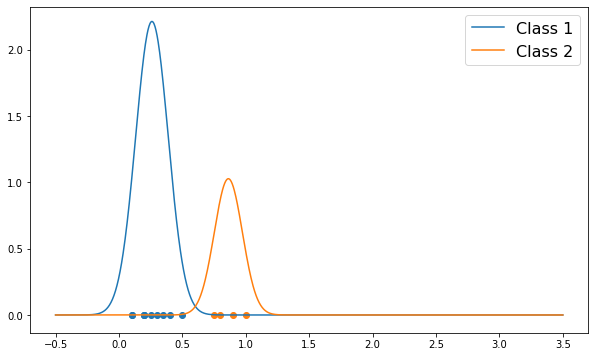

In [2]:
def univariate_gaussian_pdf(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

class_1_data = np.array([0.5, 0.1, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1, 0.35, 0.25])
class_2_data = np.array([0.9, 0.8, 0.75, 1.0])

n_class_1 = len(class_1_data)
n_class_2 = len(class_2_data)
n_total_data = n_class_1 + n_class_2

prob_class_1 = n_class_1 / n_total_data
prob_class_2 = n_class_2 / n_total_data

class_1_mean = class_1_data.mean()
class_1_std = class_1_data.std(ddof=1)

class_2_mean = class_2_data.mean()
class_2_std = class_2_data.std(ddof=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.linspace(-0.5, 3.5, 1000)

ax.plot(x, prob_class_1 * univariate_gaussian_pdf(x, class_1_mean, class_1_std), label='Class 1')
ax.scatter(class_1_data, np.zeros_like(class_1_data))

ax.plot(x, prob_class_2 * univariate_gaussian_pdf(x, class_2_mean, class_2_std), label='Class 2')
ax.scatter(class_2_data, np.zeros_like(class_2_data))

ax.legend(fontsize=16)

print('Empirical (maximum likelihood) fit for Class 1:')
print('Prior probability: {:.4f}'.format(prob_class_1))
print('Mean: {:.4f}'.format(class_1_mean))
print('Standard Deviation: {:.4f}'.format(class_1_std))
print()
print('Empirical (maximum likelihood) fit for Class 2:')
print('Prior probability: {:.4f}'.format(prob_class_2))
print('Mean: {:.4f}'.format(class_2_mean))
print('Standard Deviation: {:.4f}'.format(class_2_std))

# Q3

In [3]:
# regression model is p(y | w, x) = N(y ; w^T x, 1)
target_std = 1

def sample_gaussian(mean, precision, num_samples=400):
    # Helper function which implements the sampling method of Tutorial 2 Q4 b)
    dim = mean.shape[0]
    cholesky_precision_factor = cholesky(precision, lower=True) 
    samples = solve_triangular(cholesky_precision_factor, np.random.randn(dim, num_samples), lower=True, trans=1).T + mean
    return samples

# create a distribution object for the prior
# prior is p(w) = N(w ; [-5, 0], 2^2 * [[1, 0], [0, 1]])
prior_mean = np.array([-5, 0])
prior_std = 2
prior_precision = np.eye(2) / prior_std ** 2 

# # to sample a true weight, the function 'rvs' is using a Cholesky decomposition of the prior covariance above
# # we use this true weight to generate synthetic data 
true_weight = sample_gaussian(prior_mean, prior_precision, num_samples=1).reshape(-1)

# we sample data in two chunks using the true weight above
# chunk 1
chunk_1_mean = np.zeros(2)
chunk_1_precision = np.eye(2) / 0.5 ** 2
chunk_1_inputs = sample_gaussian(chunk_1_mean, chunk_1_precision, num_samples=15)
chunk_1_targets = chunk_1_inputs @ true_weight + target_std * np.random.randn(15)

# chunk 2
chunk_2_mean = 0.5 * np.ones(2)
chunk_2_precision = np.eye(2) / 0.1 ** 2
chunk_2_inputs = sample_gaussian(chunk_2_mean, chunk_2_precision, num_samples=30)
chunk_2_targets = chunk_2_inputs @ true_weight + target_std * np.random.randn(30)

# combine into one larg chunk for later
chunk_12_inputs = np.concatenate((chunk_1_inputs, chunk_2_inputs), axis=0)
chunk_12_targets = np.concatenate((chunk_1_targets, chunk_2_targets), axis=0)

## a)

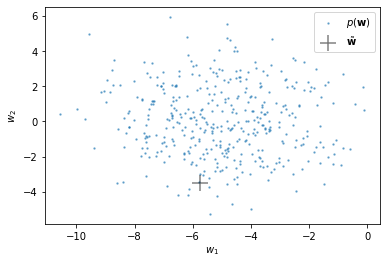

In [4]:
prior_samples = sample_gaussian(prior_mean, prior_precision, num_samples=400)

# create figure and axis objects
figure, axis = plt.subplots(1, 1)

# display prior samples
axis.scatter(prior_samples[:, 0], prior_samples[:, 1], s=2, alpha=0.5, label=r"$ p(\mathbf{w}) $")

# display true weight
axis.scatter(true_weight[0], true_weight[1], marker='+', s=250, color='k', alpha=0.5, label=r"$ \tilde{\mathbf{w}} $")

axis.set_xlabel(r"$ w_{1} $")
axis.set_ylabel(r"$ w_{2} $")

axis.legend();

Three things to say here:

- We think $ w_{1} $ is probably negative and around -5, and we think $ w_{2} $ is equally likely to be positive or negative
- Since the variance is the same for $ w_{1} $ and $ w_{2} $, we're as certain that $ w_{1} $ is close to -5 as we are that $ w_{2} $ is close to 0
- The covariance is diagonal, so we don't think there's any relationship between $ w_{1} $ and $ w_{2} $

## b)

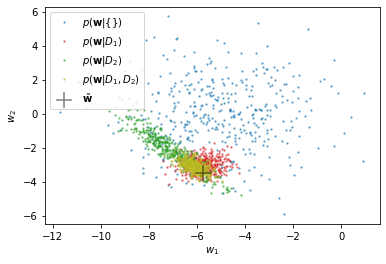

In [5]:
def get_posterior_mean_precision(inputs, targets, targets_std, prior_mean, prior_precision):
    precision = prior_precision + (1 / targets_std ** 2) * inputs.T @ inputs
    mean = solve(precision, prior_precision @ prior_mean) + solve(precision, (1 / targets_std ** 2) * inputs.T @ targets)
    return mean, precision

# get posterior parameters and samples
# p(w | D1)
posterior_1_mean, posterior_1_precision = get_posterior_mean_precision(
    chunk_1_inputs, 
    chunk_1_targets, 
    target_std, 
    prior_mean, 
    prior_precision
)
posterior_1_samples = sample_gaussian(posterior_1_mean, posterior_1_precision)

# p(w | D2)
posterior_2_mean, posterior_2_precision = get_posterior_mean_precision(
    chunk_2_inputs, 
    chunk_2_targets, 
    target_std, 
    prior_mean, 
    prior_precision
)
posterior_2_samples = sample_gaussian(posterior_2_mean, posterior_2_precision)

# p(w | D1, D2)
posterior_12_mean, posterior_12_precision = get_posterior_mean_precision(
    chunk_12_inputs, 
    chunk_12_targets, 
    target_std, 
    prior_mean, 
    prior_precision
)
posterior_12_samples = sample_gaussian(posterior_12_mean, posterior_12_precision)

# p(w | {})
inputs, targets = np.empty((0, 2)), np.empty((0))
posterior_empty_mean, posterior_empty_precision = get_posterior_mean_precision(
    inputs,
    targets, 
    target_std,
    prior_mean, 
    prior_precision
)
posterior_empty_samples = sample_gaussian(posterior_empty_mean, posterior_empty_precision)

figure, axis = plt.subplots(1, 1)

# p(w | {}) is p(w), the prior
axis.scatter(posterior_empty_samples[:, 0], posterior_empty_samples[:, 1], s=2, alpha=0.5, label=r"$ p(\mathbf{w} \vert \{ \}) $")

# p(w | D1)
axis.scatter(posterior_1_samples[:, 0], posterior_1_samples[:, 1], color='C3', s=2, alpha=0.5, label=r"$ p(\mathbf{w} \vert D_{1}) $")

# p(w | D2)
axis.scatter(posterior_2_samples[:, 0], posterior_2_samples[:, 1], color='C2', s=2, alpha=0.5, label=r"$ p(\mathbf{w} \vert D_{2}) $")

# p(w | D1, D2)
axis.scatter(posterior_12_samples[:, 0], posterior_12_samples[:, 1], color='C8', s=2, alpha=0.5, label=r"$ p(\mathbf{w} \vert D_{1}, D_{2}) $")

# true weight
axis.scatter(true_weight[0], true_weight[1], marker='+', s=250, color='k', alpha=0.5, label=r"$ \tilde{\mathbf{w}} $")

axis.set_xlabel(r"$ w_{1} $")
axis.set_ylabel(r"$ w_{2} $")

axis.legend();

With more data, the posterior becomes sharper, narrowing in on the true weights. Notice how $ p(\mathbf{w} \vert D_{1}, D_{2}) $ has density distributed at the intersection of $ p(\mathbf{w} \vert D_{1}) $ and $ p(\mathbf{w} \vert D_{2}) $. This is the geometric effect of the likelihood product $ p(D_{2} \vert \mathbf{w}) p(D_{1} \vert \mathbf{w}) $ appearing in Bayes' rule.

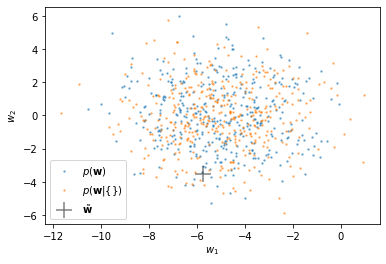

In [6]:
figure, axis = plt.subplots(1, 1)

# prior p(w)
axis.scatter(prior_samples[:, 0], prior_samples[:, 1], s=2, alpha=0.5, label=r"$ p(\mathbf{w}) $")

# p(w | {}) is p(w), the prior
axis.scatter(posterior_empty_samples[:, 0], posterior_empty_samples[:, 1], s=2, alpha=0.5, label=r"$ p(\mathbf{w} \vert \{ \}) $")

# true weight
axis.scatter(true_weight[0], true_weight[1], marker='+', s=250, color='k', alpha=0.5, label=r"$ \tilde{\mathbf{w}} $")

axis.set_xlabel(r"$ w_{1} $")
axis.set_ylabel(r"$ w_{2} $")

axis.legend();

The posterior given an empty data set is just the prior.

## c)

In [7]:
# calculate p(w) ~ p(D2 |w) p(w | D1) i.e. use p(w | D1) as the prior
posterior_mean, posterior_precision = get_posterior_mean_precision(
    chunk_2_inputs, 
    chunk_2_targets,
    target_std, 
    posterior_1_mean,
    posterior_1_precision
)
print(f'p(w | D1, D2) = N(w ; mean={posterior_12_mean}, precision={posterior_12_precision})')
print(f'p(D2 | w) p(w | D1) ~ N(w ; mean={posterior_mean}, precision={posterior_precision})')

p(w | D1, D2) = N(w ; mean=[-6.12491    -3.09234631], precision=[[10.80379592  6.67754033]
 [ 6.67754033 12.06764814]])
p(D2 | w) p(w | D1) ~ N(w ; mean=[-6.12491    -3.09234631], precision=[[10.80379592  6.67754033]
 [ 6.67754033 12.06764814]])


The posteriors are exactly the same, meaning it doesn't matter in which order we update our posterior, we will always get the same result once we've seen all the data. 

## d)

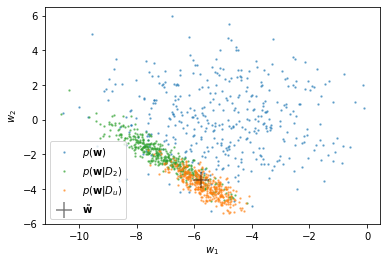

In [8]:
chunk_2_uniform_inputs = np.random.rand(15, 2)
chunk_2_uniform_targets = chunk_2_uniform_inputs @ true_weight + target_std * np.random.randn(15)

posterior_uniform_chunk_mean, posterior_uniform_chunk_precision = get_posterior_mean_precision(
    chunk_2_uniform_inputs, 
    chunk_2_uniform_targets,
    target_std,
    prior_mean, 
    prior_precision
)
posterior_uniform_chunk_samples = sample_gaussian(posterior_uniform_chunk_mean, posterior_uniform_chunk_precision, num_samples=400)

figure, axis = plt.subplots(1, 1)

# prior p(w)
axis.scatter(prior_samples[:, 0], prior_samples[:, 1], s=2, alpha=0.5, label=r"$ p(\mathbf{w}) $")

# posterior p(w | D2)
axis.scatter(posterior_2_samples[:, 0], posterior_2_samples[:, 1], color='C2', s=2, alpha=0.5, label=r"$ p(\mathbf{w} \vert D_{2}) $")

# posterior p(w | Du) 
axis.scatter(posterior_uniform_chunk_samples[:, 0], posterior_uniform_chunk_samples[:, 1], s=2, alpha=0.5, label=r"$ p(\mathbf{w} \vert D_{u}) $")

# true weight
axis.scatter(true_weight[0], true_weight[1], marker='+', s=250, color='k', alpha=0.5, label=r"$ \tilde{\mathbf{w}} $")

axis.set_xlabel(r"$ w_{1} $")
axis.set_ylabel(r"$ w_{2} $")

axis.legend();

Uniformly distributed input data leads to slightly sharper posterior estimate for weights. See answers for discussion.

## e) & f)

Discussion